In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
import itertools

%matplotlib inline

# Predict Future Sales

## 1. Load Data

In [10]:
df_train = pd.read_csv('../data/raw/sales_train.csv')
df_test = pd.read_csv('../data/raw/test.csv')
df_items = pd.read_csv('../data/raw/items.csv')
df_item_categories = pd.read_csv('../data/item_categories_kor.csv')
df_shops = pd.read_csv('../data/raw/shops.csv')

In [3]:
# null check
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


## 2. Preprocessing

### 중복 체크 - Shop name

In [6]:
# 0, 57 중복 / 1, 58 중복 -> train 데이터에서 동일 인덱스 처리
df_shops.iloc[[0,1,57,58]]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58


### 이상치 제거

- item_cnt_day : 1000
- item_price : 30만

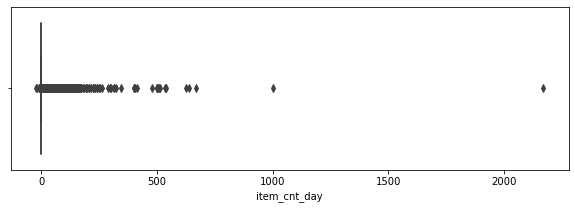

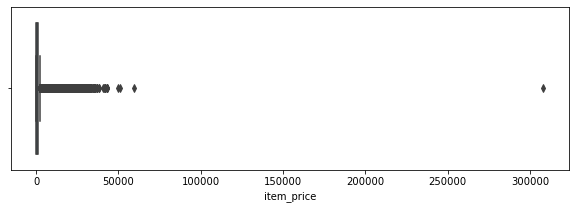

In [7]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=df_train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=df_train);

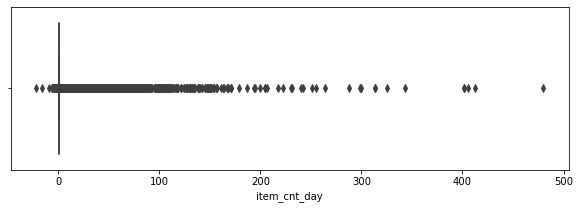

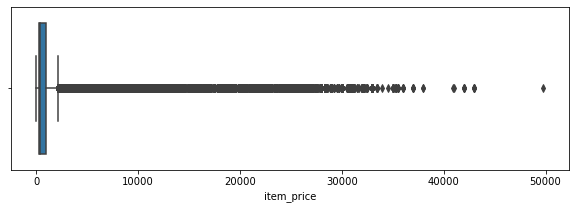

In [8]:
df_train = df_train[df_train.item_cnt_day < 500]
df_train = df_train[df_train.item_price < 50000]

plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=df_train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=df_train);

## 3. Create Feature

### 3.1 Matrix 생성

- test.csv의 shop 기준으로 Matrix 생성.
- date_block_num : 0~34 (예측월까지 병합)

In [37]:
shops = df_test.shop_id.unique()
date_block_num = 34
shops

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45], dtype=int64)

In [56]:
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    condition = (df_train.date_block_num == i)&(df_train.shop_id.isin(shops))
    sales = df_train[condition]
    matrix.append(np.array(list(itertools.product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

In [57]:
# int8 -> Byte (-128 to 127), int16 -> Integer (-32768 to 32767)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)

In [58]:
matrix.tail()

,date_block_num,shop_id,item_id
8467154,33,59,22162
8467344,33,59,22163
8468010,33,59,22164
8469536,33,59,22166
8468831,33,59,22167


In [59]:
df_test['date_block_num'] = 34
df_test['date_block_num'] = df_test['date_block_num'].astype(np.int8)
df_test['shop_id'] = df_test['shop_id'].astype(np.int8)
df_test['item_id'] = df_test['item_id'].astype(np.int16)
df_test.drop(columns='ID', inplace=True)
df_test.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [60]:
matrix = pd.concat([matrix, df_test], axis=0)

In [71]:
matrix

,date_block_num,shop_id,item_id,city_id,shop_type_id,item_category_id,type_code,subtype_code
0,0,2,19,14,1,40,8,3
1,0,2,27,14,1,19,2,7
2,0,2,28,14,1,30,1,13
3,0,2,29,14,1,23,2,15
4,0,2,32,14,1,40,8,3
...,...,...,...,...,...,...,...,...
8812239,34,45,18454,10,1,55,11,57
8812240,34,45,16188,10,1,64,7,38
8812241,34,45,15757,10,1,55,11,57
8812242,34,45,19648,10,1,40,8,3


### 3.2 Encoding

### shops

In [23]:
shp_city = ['야쿠츠크', '야쿠츠크', '아디게야', '발라시하', '볼츠스키',
           '볼로그다', '보로네슈', '보로네슈','보로네슈', '브로네슈',
           '쥬코브스키', '쥬코브스키', '온라인', '카잔', '카잔',
           '칼루가', '콜롬나', '크라스노야르스크', '크라스노야르스크', '쿠르스크',
           '모스크바', '모스크바', '모스크바', '모스크바', '모스크바',
           '모스크바', '모스크바', '모스크바', '모스크바', '모스크바',
           '모스크바', '모스크바', '모스크바', '미티시치', '니즈니노브고로드',
           '니즈니노브고로드', '노보시비르스크','노보시비르스크', '옴스크', '로스토프온돈',
           '로스토프온돈', '로스토프온돈', '상트페테르부르크', '상트페테르부르크', '사마라',
           '사마라', '세르기예프 포사트', '수르구트', '톰스크', '투먼',
           '투먼', '투먼', '우파', '우파', '힘키',
           '모스크바','체호프', '아쿠츠크', '아쿠츠크', '야로슬라블']
shp_type = ['기타', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '기타', '쇼핑몰', '쇼핑몰', '기타',
           '기타', '기타', '온라인몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '기타', '쇼핑몰', '쇼핑몰', '컴퓨터용품점', '컴퓨터용품점',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰',
           '컴퓨터용품점', '쇼핑몰', '쇼핑몰', '쇼핑몰', '쇼핑몰']

In [64]:
le = LabelEncoder()
df_shops['city_id'] = le.fit_transform(shp_city)
df_shops['shop_type_id'] = le.fit_transform(shp_type)
df_shops.drop(columns='shop_name', inplace=True)
df_shops.head()

,shop_id,city_id,shop_type_id
0,0,17,0
1,1,17,1
2,2,14,1
3,3,5,1
4,4,8,1


#### Item Category

In [11]:
cat1, cat2 = [], []
for n in df_item_categories.item_category_name:
    
    _ = n.split('-')
    cat1.append(_[0].strip())
    try: 
        cat2.append(_[1].strip())
    except:
        cat2.append(np.nan)
        
cat1[-5:], cat2[-5:]

(['서비스', '서비스', '클린 미디어 (첨탑)', '클린 미디어 (조각)', '전원 요소'],
 [nan, '티켓', nan, nan, nan])

In [21]:
le = LabelEncoder()
df_item_categories['type_code'] = le.fit_transform(cat1)
df_item_categories['subtype_code'] = le.fit_transform(cat2)

In [65]:
df_item_categories.drop(columns='item_category_name', inplace=True)
df_item_categories.head()

,item_category_id,type_code,subtype_code
0,0,0,61
1,1,10,6
2,2,10,7
3,3,10,8
4,4,10,10


### Items

In [66]:
# item_id로 인코딩 대체
df_items.drop(columns='item_name', inplace=True)
df_items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


### Matrix에 병합

In [62]:
matrix.head()

,date_block_num,shop_id,item_id
83827,0,2,19
86076,0,2,27
88952,0,2,28
87002,0,2,29
83503,0,2,32


In [68]:
matrix = pd.merge(matrix, df_shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, df_items, on=['item_id'], how='left')
matrix = pd.merge(matrix, df_item_categories, on=['item_category_id'], how='left')
matrix['city_id'] = matrix['city_id'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [70]:
matrix.tail()

,date_block_num,shop_id,item_id,city_id,shop_type_id,item_category_id,type_code,subtype_code
8812239,34,45,18454,10,1,55,11,57
8812240,34,45,16188,10,1,64,7,38
8812241,34,45,15757,10,1,55,11,57
8812242,34,45,19648,10,1,40,8,3
8812243,34,45,969,10,1,37,20,41


### 3.3 수치데이터 생성(price, cnt, mean, lag 등)

In [73]:
matrix.tail(61)

,date_block_num,shop_id,item_id,city_id,shop_type_id,item_category_id,type_code,subtype_code
8812183,34,45,10977,10,1,37,20,41
8812184,34,45,10508,10,1,37,20,41
8812185,34,45,10697,10,1,49,15,36
8812186,34,45,8799,10,1,40,8,3
8812187,34,45,8798,10,1,40,8,3
...,...,...,...,...,...,...,...,...
8812239,34,45,18454,10,1,55,11,57
8812240,34,45,16188,10,1,64,7,38
8812241,34,45,15757,10,1,55,11,57
8812242,34,45,19648,10,1,40,8,3
